In [1]:
# imports
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from preprocessing_tools import check_for_nan_columns, drop_nan_columns
from ml_tools import stratified_clf_cv_accuracy
from functools import partial
from scipy import stats
from scipy.stats import randint

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV,
                                     cross_val_predict)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (mean_squared_error, make_scorer, confusion_matrix,
                            precision_score, recall_score, f1_score, accuracy_score,
                            precision_recall_curve, roc_curve, roc_auc_score)

In [2]:
df = pd.read_parquet('NYSE_dataset_v2_linregress.parquet')
df = df.drop(['priceRatioRelativeToS&P_1Q', 'priceRatioRelativeToS&P_3Q', 
              'priceRatioRelativeToS&P_4Q'], axis=1)

# making the output binary
df['priceRatioRelativeToS&P_2Q'] = \
    df['priceRatioRelativeToS&P_2Q'].apply(lambda x: 1 if x>=1 else 0)

input_df = df.drop('priceRatioRelativeToS&P_2Q', axis=1).copy()
output_df = df['priceRatioRelativeToS&P_2Q'].copy().to_frame()

X_train, X_test, y_train, y_test = train_test_split(input_df, 
                                                    output_df,
                                                    random_state=42,
                                                    test_size=0.2
                                                   )

# scaling data
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
# categorical outputs dont need to be scaled

## Stochastic Gradient Descent
We first inspect the distribution of outcomes in the y_train set to determine if there is any imbalance in the classes. We anticipate each class to represent around 50% of the total. This is intuitive: the metric measures whether a company's stock price has done better than the market average. We would expect half of the companies to have done better than the market, and half worse.

In [3]:
(y_train == 0).sum()/len(y_train)

0.5128573648228714

We thus see that our intuitions are correct. **Since the outcomes in the dataset are balanced, we can safely use accuracy as a performance metric on this data.** We proceed now to train the SGDClassifier

In [4]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

# using cross-validation and checking accuracy
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.52631579, 0.53777433, 0.49873762, 0.53311323, 0.53496503])

In [5]:
# We note that we get the same result from our custom-built CV function
stratified_clf_cv_accuracy(sgd_clf, X_train_scaled, y_train, n_splits=5)

array([0.52631579, 0.53777433, 0.49873762, 0.53311323, 0.53496503])

In [6]:
# comparison to a dummy classifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
cross_val_score(dummy_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.51272092, 0.51291513, 0.51291513, 0.51291513, 0.51282051])

We see that our SGDClassifier is only marginally better than a dummy classifier. This is not very impressive! We now inspect the confusion matrix. We see that we are getting many false positives and many false negatives. The model seems to be slightly better at predicting the positive outcomes.

In [7]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)
cm = confusion_matrix(y_train, y_train_pred)
cm
## [0,0] = true negatives
## [1,0] = false negatives
## [0,1] = false positives
## [1,1] = true positives

array([[7531, 5672],
       [6526, 6015]], dtype=int64)

## Performance Metrics
Note the following definitions for the precision, recall, and F1 metrics:

**Precision**

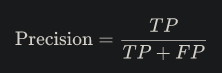
Remember that precision is the accuracy of your positive predictions, i.e. of the total positive predictions, how many were correct predictions?

**Recall**

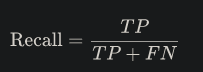
Recall is sometimes called sensitivity or the true positive rate. This is the ratio of true positive instances that are correctly classified.

**F1**


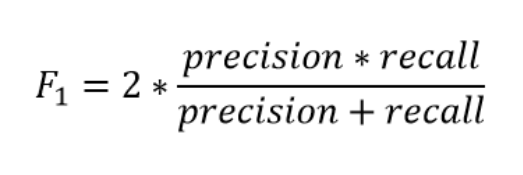
The F1 score is a score that combines precision and recall and is useful when comparing two classifiers. The F1 tends to prefer classifiers with similar precision and recall values. This is often not desired, as one label will be more important than the other.

In [8]:
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred), \
    f1_score(y_train, y_train_pred)

(0.5146744245743133, 0.4796268240172235, 0.49653293709757307)

### The Precision-Recall Tradeoff
There is a tradeoff between precision and recall. Optimising for one will have a negative impact on the other. 

The SGDClassifier works by computing scores for samples based on a decision function. The sample score is compared to a threshold and the sample is assigned an outcome based on that threshold. We cannot set the threshold directly, but we can instead access the decision scores and then select our own threshold to make predictions. The default threshold is 0.

In [9]:
y_train_scores = sgd_clf.decision_function(X_train_scaled)
y_train_scores

array([-0.84215035,  0.03100847, -0.76867499, ...,  0.695796  ,
        0.71521867,  0.726132  ])

We can also obtain scores for each fold in a cross-validation. The precision-recall curve can then be plotted by varying the threshold and studying the effect on the metrics.

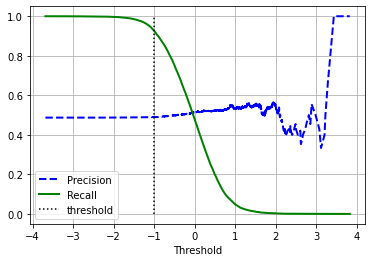

In [10]:
y_train_scores_cv = cross_val_predict(sgd_clf, X_train_scaled, y_train,
                                     cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train, 
                                                         y_train_scores_cv)

threshold_example = -1
plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.vlines(threshold_example, 0, 1.0, "k", "dotted", label='threshold')
plt.grid()
plt.xlabel("Threshold")
plt.legend()
plt.show()

Note the smooth recall curve yet the bumby precision curve. Precision can only decrease as the threshold increases, whereas precision can move in either direction, which often results in a bumpy ride.

The curves above do not paint a good picture for the classifier. We would ideally like a high precision, such that we can be certain that a positive prediciton will be a safe bet as a stock purchase. But unfortunately, obtaining a precision higher than 0.6 will drop recall down to zero, which will essentially means that the classifier is never making any positive predictions in the first place and has in effect become a dummy classifier. 

We could however obtain a high recall with a precision of around 0.5. This will however again result in a dummy classifier that is always predicting positive, and the recall automatically becomes 0.5 due to the even label distribution in the dataset.

It is also possible to plot precision against recall directly, as shown below. Again we see non-ideal behaviour, as ideally this curve would look like the curve of a hyperbola.:

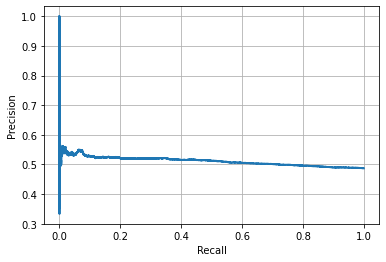

In [11]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

Let us for demonstration purposes assume we want 80% recall. We could the threshold off the plot, but this would not be accurate. Instead we use numpy to find the index.

In [12]:
idx_for_80_recall = (recalls <= 0.8).argmax()
threshold_for_80_recall = thresholds[idx_for_80_recall]
threshold_for_80_recall
idx_for_80_recall


5513

Now instead of calling predict() on the classifier, we do the following:

In [13]:
y_train_pred_80_recall = (y_train_scores_cv >= threshold_for_80_recall)

precision_score(y_train, y_train_pred_80_recall), \
    recall_score(y_train, y_train_pred_80_recall)

(0.4958726706539469, 0.7999362092337134)

We thus have a classifier with 80% recall and 50% precision. Remember however that this is in no way good performance. We are somewhat ensuring that the true positives are being classified as such, but this is essntially a dummy classifier that is blindly predicting positive outcomes, hence the 50% precision on the evenly distributed labels.

### The ROC Curve
This curve plots the true positive rate against the false positive rate. Again we see that the classifier is only marginally more performant that a random classifier.

Note that the ROC curve is very similar to the precision recall curve. Generally, the PR curve is preferred whenever the positive class is rare or when you care more about false positives than false negatives. Otherwise, the ROC curve should be used. In our case, false positives are detrimental as this would result in us choosing to invest in stocks that turn out to be duds.

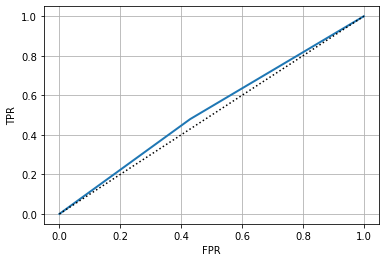

In [14]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0,1], [0,1], "k:")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

## Random Forrest Classification
The precision_racall_curve() function expects true labels and scores. RandomForestClf() does not provide scores, but it does provide probabilities. The second column of the probabilities is the probability for the positive outcome.

In [15]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1)
y_probs_forest = cross_val_predict(forest_clf, X_train_scaled, y_train_pred, cv=3, method='predict_proba')

Text(0, 0.5, 'Precision')

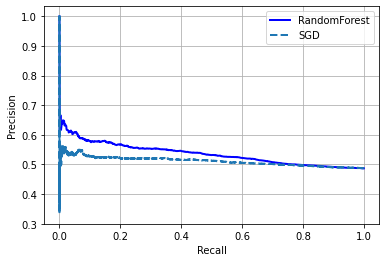

In [16]:
y_scores_forest = y_probs_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label='RandomForest')
plt.plot(recalls, precisions,  "--", linewidth=2, label='SGD')
plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

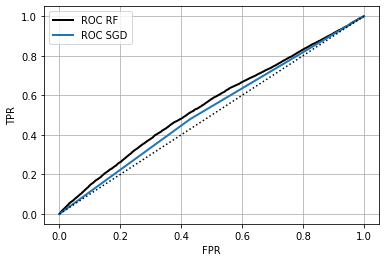

In [17]:
fpr_forest, tpr_forest, thresholds_forest_roc = roc_curve(y_train, y_scores_forest)

plt.plot(fpr_forest, tpr_forest, 'k-', linewidth=2, label='ROC RF')
plt.plot(fpr, tpr, linewidth=2, label='ROC SGD')
plt.plot([0,1], [0,1], "k:")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend()
plt.show()

We see that the RandomForest is more performant than the SGD classifier, but the overall performance is still poor.

Since decision trees are not concerned with te scale of data, we can train the random forest on the original dataset as opposed to the one that was prepared for linear models.

In [18]:
data = pd.read_parquet('NYSE_dataset_cleaned_with_outliers.parquet')
data = data.drop(['date', 'period', 'company', 
                  'priceRatioRelativeToS&P_1Q', 
                  'priceRatioRelativeToS&P_3Q',
                 'priceRatioRelativeToS&P_4Q'], axis=1)
data = data[~data['priceRatioRelativeToS&P_2Q'].isna()]
X = data.drop('priceRatioRelativeToS&P_2Q', axis=1).copy()
y = data['priceRatioRelativeToS&P_2Q'].copy()
y = y.apply(lambda x: 1 if x >=1 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
forest_clf = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=100)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train, cv=5, method='predict_proba')

Text(0, 0.5, 'Precision')

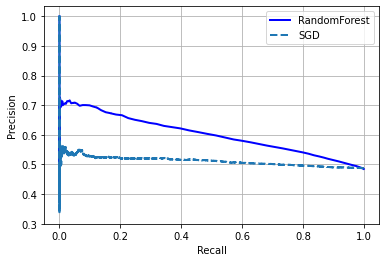

In [20]:
y_scores_forest = y_probs_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label='RandomForest')
plt.plot(recalls, precisions,  "--", linewidth=2, label='SGD')
plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

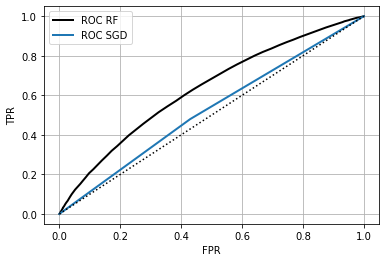

In [21]:
fpr_forest, tpr_forest, thresholds_forest_roc = roc_curve(y_train, y_scores_forest)

plt.plot(fpr_forest, tpr_forest, 'k-', linewidth=2, label='ROC RF')
plt.plot(fpr, tpr, linewidth=2, label='ROC SGD')
plt.plot([0,1], [0,1], "k:")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend()
plt.show()

Including all the data obviously is much better for the model, as it performs much better than when the features were hand-picked.

In [22]:
forest_clf.fit(X_train, y_train)
y_train_pred = forest_clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9999388454011742

In [23]:
confusion_matrix(y_train, y_train_pred)

array([[25254,     0],
       [    3, 23799]], dtype=int64)

We see that the ROC curve and precision-recall curve are nowhere near perfect, but when training on the full dataset we get basically perfect accuracy. What is going on here?

Remember that precision/recall and ROC are evaluated using cross-validation, so the model is continually trained on k-1 folds and then evaluated on the unseen fold to assess performance. This gives a better indication of performance. Indeed, if we evaluate our "nearly perfect" model on the test set, we likely will not get such great results!

In [24]:
y_test_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.6026417171161255

And thus we see that the model has severely overfit the training data. Although, it's still doing better on the test set than it ever has before!

When we were doing regression, we manually selected the features we wanted. Random forests actually allow us to see the relative importance of each feature, which can be very useful for feature selection.

In [26]:
for score, name in zip(forest_clf.feature_importances_, X.columns):
    print(round(score, 2), name)

"""Again we see that the correlations are very weak"""

0.01 assetTurnover
0.01 capitalExpenditureCoverageRatio
0.01 cashConversionCycle
0.01 cashFlowToDebtRatio
0.01 cashPerShare
0.01 cashRatio
0.01 companyEquityMultiplier
0.01 currentRatio
0.01 daysOfInventoryOutstanding
0.01 daysOfPayablesOutstanding
0.01 daysOfSalesOutstanding
0.01 dividendPaidAndCapexCoverageRatio
0.01 dividendYield
0.01 ebtPerEbit
0.01 effectiveTaxRate
0.01 enterpriseValueMultiple
0.01 fixedAssetTurnover
0.01 freeCashFlowOperatingCashFlowRatio
0.01 freeCashFlowPerShare
0.01 grossProfitMargin
0.01 interestCoverage
0.01 inventoryTurnover
0.01 longTermDebtToCapitalization
0.01 netIncomePerEBT
0.01 netProfitMargin
0.01 operatingCashFlowPerShare
0.01 operatingCashFlowSalesRatio
0.01 operatingCycle
0.01 operatingProfitMargin
0.01 payablesTurnover
0.01 payoutRatio
0.01 pretaxProfitMargin
0.02 priceEarningsToGrowthRatio
0.01 priceToBookRatio
0.01 priceToFreeCashFlowsRatio
0.01 priceToOperatingCashFlowsRatio
0.02 priceToSalesRatio
0.01 quickRatio
0.01 receivablesTurnover
0.01 

'Again we see that the correlations are very weak'